In [1]:
import argparse
import os
import pickle
import random
import sys
import time
from importlib import import_module
from scipy import sparse
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import matplotlib.pyplot as plt
from skimage.transform import rotate
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from data import ArgoDataset as Dataset, from_numpy, ref_copy, collate_fn
from utils import Logger, load_pretrain, gpu, to_long,  Optimizer, StepLR
torch.cuda.set_device(1)

am = ArgoverseMap()

data_path = '/data/fyy/lanegcn/dataset/dataset/val/data'
avl = ArgoverseForecastingLoader(data_path)
avl.seq_list = sorted(avl.seq_list)

In [22]:
def get_traj_and_lane(idx): 
    city_name = copy.deepcopy(avl[idx].city)
    data_seq = copy.deepcopy(avl[idx].seq_df)   # (len, 6)
    timestamp = np.sort(np.unique(data_seq['TIMESTAMP'].values))
    
    mapping = dict()
    for i, ts in enumerate(timestamp):
        mapping[ts] = i
        
    # 某个场景下的所有轨迹，5s内的轨迹，(len, 2)
    trajs = np.concatenate((
            data_seq.X.to_numpy().reshape(-1, 1),
            data_seq.Y.to_numpy().reshape(-1, 1)), 1)

    steps = [mapping[x] for x in data_seq['TIMESTAMP'].values]
    steps = np.asarray(steps, np.int64)

    objs = data_seq.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
    keys = list(objs.keys())
    obj_type = [x[1] for x in keys]

    av_idx = obj_type.index('AV')  # av_index = 0，获取AV的索引
    idcs = objs[keys[av_idx]]

    av_traj = trajs[idcs]  # av_traj.shape = (50, 2)
    av_step = steps[idcs]  # av_step.shape = (50,)
    
    # 获取周围车辆的轨迹
    del keys[av_idx]
    ctx_trajs, ctx_steps = [], []  
    for key in keys:
        idcs = objs[key]
        ctx_trajs.append(trajs[idcs])
        ctx_steps.append(steps[idcs])
        
    data = dict()
    data['city'] = city_name
    data['trajs'] = [av_traj] + ctx_trajs
    data['steps'] = [av_step] + ctx_steps
    data['argo_id'] = int(avl.seq_list[idx].name[:-4])
    
    av_lane = am.get_lane_ids_in_xy_bbox(av_traj[0][0], av_traj[0][1], city_name, 20)
    return av_traj, av_lane, timestamp[0], city_name

In [22]:
len(avl.seq_list)

39472

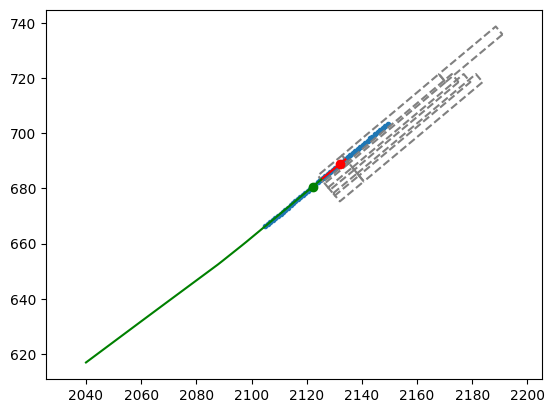

In [25]:
straight_idx = []
left_idx = []
right_idx = []
# for i in tqdm(range(len(avl)), desc="Processing"):
for i in range(94, 95):
    av_traj, av_lane, _, city_name = get_traj_and_lane(i)
    closest_lane_obj, _, dense_centerline = am.get_nearest_centerline(av_traj[20], city_name)
    if closest_lane_obj == None or closest_lane_obj.is_intersection == True:
        continue    
    orig = [list(dense_centerline[0])]    # 轨迹第20帧所在车道, 起始坐标
    
    #############################前后车道##################################
    s_ctr = []
    if closest_lane_obj.predecessors != None:
        for idx in closest_lane_obj.predecessors:
            if am.get_lane_turn_direction(idx, city_name) == 'NONE':
                pre_lane = am.dfs(idx, city_name, 30, extend_along_predecessor = True)[0]
                for pre_id in pre_lane:
                    s_ctr.append(list(am.get_lane_segment_centerline(pre_id, city_name)[0])[:2])    # 前一车道, 起始坐标
                    # polygon = am.get_lane_segment_polygon(pre_id, city_name)
                    # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')

    if closest_lane_obj.successors != None:
        for idx in closest_lane_obj.successors:
            if am.get_lane_turn_direction(idx, city_name) == 'NONE':
                suc_lane = am.dfs(idx, city_name, 30, extend_along_predecessor = False)[0]
                for suc_id in suc_lane:
                    s_ctr.append(list(am.get_lane_segment_centerline(suc_id, city_name)[0])[:2])    # 后一车道, 起始坐标
                    # polygon = am.get_lane_segment_polygon(suc_id, city_name)
                    # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
        
    #############################左车道前后##################################
    l_ctr = []
    if closest_lane_obj.l_neighbor_id != None:
        l_pre_lane = am.dfs(closest_lane_obj.l_neighbor_id, city_name, 30, extend_along_predecessor = True)[0]
        l_suc_lane = am.dfs(closest_lane_obj.l_neighbor_id, city_name, 30, extend_along_predecessor = False)[0]
        for l_pre_id in l_pre_lane:
            l_ctr.append(list(am.get_lane_segment_centerline(l_pre_id, city_name)[0])[:2]) 
            # polygon = am.get_lane_segment_polygon(l_pre_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')  
        for l_suc_id in l_suc_lane:
            l_ctr.append(list(am.get_lane_segment_centerline(l_suc_id, city_name)[0])[:2])
            # polygon = am.get_lane_segment_polygon(l_suc_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
    
    #############################右车道的前后##################################
    r_ctr = []
    if closest_lane_obj.r_neighbor_id != None:
        r_pre_lane = am.dfs(closest_lane_obj.r_neighbor_id, city_name, 30, extend_along_predecessor = True)[0]
        r_suc_lane = am.dfs(closest_lane_obj.r_neighbor_id, city_name, 30, extend_along_predecessor = False)[0]
        for r_pre_id in r_pre_lane:
            r_ctr.append(list(am.get_lane_segment_centerline(r_pre_id, city_name)[0])[:2]) 
            # polygon = am.get_lane_segment_polygon(r_pre_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
        for r_suc_id in r_suc_lane:
            r_ctr.append(list(am.get_lane_segment_centerline(r_suc_id, city_name)[0])[:2])
            # polygon = am.get_lane_segment_polygon(r_suc_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')   
            
        
        
        
        
    closest_lane_obj_end, _, dense_centerline_end = am.get_nearest_centerline(av_traj[30], city_name) 
    if closest_lane_obj_end == None or closest_lane_obj_end.is_intersection == True:
        continue
    cur = list(dense_centerline_end[0])   # 最末帧轨迹所在车道, 起始坐标
    
    if cur in s_ctr:
        straight_idx.append(i)
    elif cur in l_ctr:
        left_idx.append(i)
    elif cur in r_ctr:
        right_idx.append(i)
    else:
        continue
    
    
    # plt.plot(av_traj[:, 0], av_traj[:, 1], '.')
    # for lane_id in av_lane:
    #     polygon = am.get_lane_segment_polygon(lane_id, city_name)
    #     plt.plot(polygon[:, 0], polygon[:, 1], '--', color = 'grey')
    # plt.plot(dense_centerline[:, 0], dense_centerline[:, 1], 'red')
    
    # plt.plot(av_traj[19, 0], av_traj[19, 1], '-o', color = 'r')
    # plt.plot(av_traj[30, 0], av_traj[30, 1], '-o', color = 'green')
    # c3 = dense_centerline_end
    # plt.plot(c3[:, 0], c3[:, 1], 'green')
    
    
    # plt.axis('equal')
 

In [27]:
print(straight_idx)
print(left_idx)
print(right_idx)

[94]
[]
[]


In [28]:
[straight_idx]+[left_idx]+[right_idx]

[[94], [], []]

In [4]:
import pickle
file_name = '/data/fyy/new_prediction/argoverse copy/intersection_data/changelane_val_idx.pkl'

# with open(file_name, 'wb') as file:
#     pickle.dump(changelane_idx, file)
    
# with open(file_name, 'rb') as file:
#     intention_data = pickle.load(file)

print("意图数据的数量", len(changelane_idx))

意图数据的数量 1
